In [1]:
!pip install transformers datasets accelerate pyarrow scikit-learn pyvi
!pip install -q -U google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

# Đường dẫn cơ sở đến các file Parquet đã được chuyển đổi
base_url = "https://huggingface.co/datasets/uitnlp/vietnamese_students_feedback/resolve/refs/convert/parquet/default/"

# Định nghĩa các file cho từng split
data_files = {
    "train": base_url + "train/0000.parquet",
    "validation": base_url + "validation/0000.parquet",
    "test": base_url + "test/0000.parquet"
}

# Tải dữ liệu bằng cách chỉ định type là "parquet" và cung cấp data_files
raw_datasets = load_dataset("parquet", data_files=data_files)

print(raw_datasets)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


default/train/0000.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

default/validation/0000.parquet:   0%|          | 0.00/63.3k [00:00<?, ?B/s]

default/test/0000.parquet:   0%|          | 0.00/134k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})


/tmp/ipython-input-1769677885.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x="label_text", ax=axes[0], palette="viridis", order=["Negative", "Neutral", "Positive"])


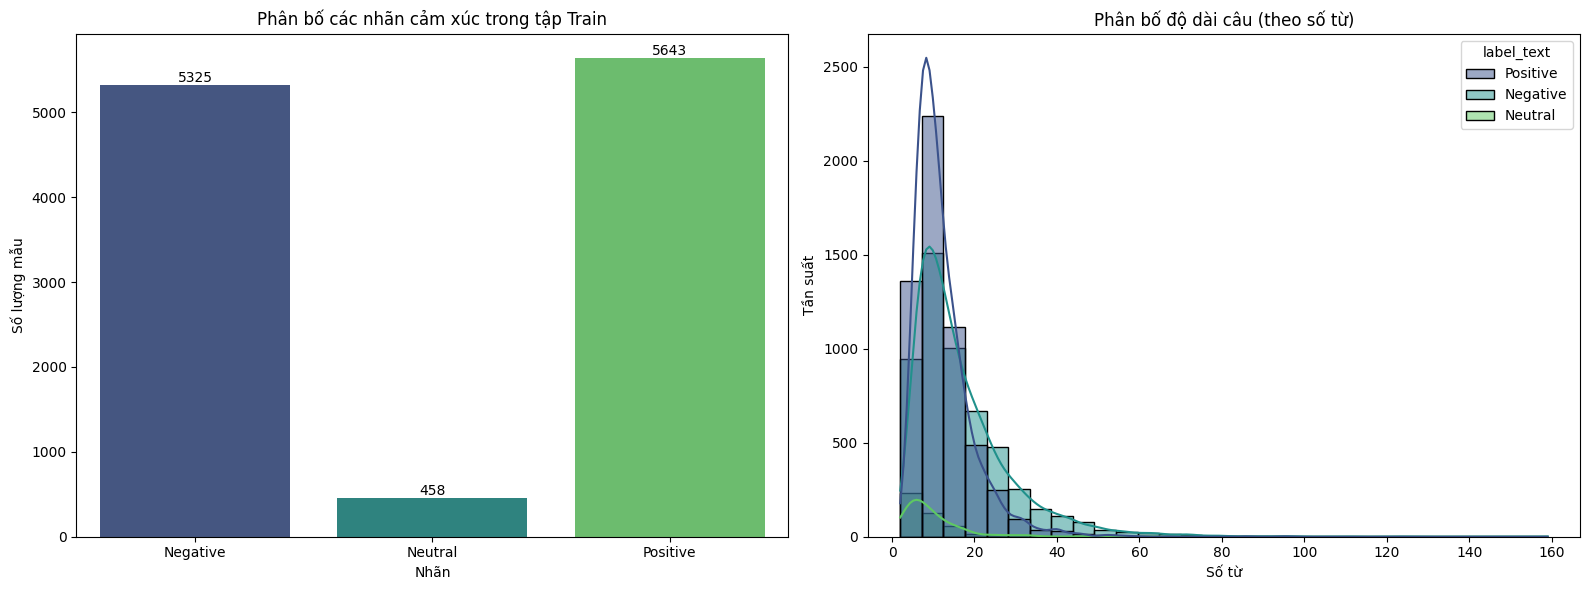

Độ dài câu trung bình: 14.31 từ
Độ dài câu lớn nhất: 159 từ


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Chuyển dataset train sang pandas DataFrame để dễ vẽ
df_train = pd.DataFrame(raw_datasets["train"])

# Map nhãn số sang chữ cho dễ hiểu
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df_train["label_text"] = df_train["sentiment"].map(label_map)

# Tính độ dài câu (số từ)
df_train["word_count"] = df_train["sentence"].apply(lambda x: len(x.split()))

# --- VẼ BIỂU ĐỒ ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Biểu đồ phân bố nhãn (Class Distribution)
sns.countplot(data=df_train, x="label_text", ax=axes[0], palette="viridis", order=["Negative", "Neutral", "Positive"])
axes[0].set_title("Phân bố các nhãn cảm xúc trong tập Train")
axes[0].set_xlabel("Nhãn")
axes[0].set_ylabel("Số lượng mẫu")
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# 2. Biểu đồ phân bố độ dài câu (Sentence Length)
sns.histplot(data=df_train, x="word_count", hue="label_text", kde=True, ax=axes[1], palette="viridis", bins=30)
axes[1].set_title("Phân bố độ dài câu (theo số từ)")
axes[1].set_xlabel("Số từ")
axes[1].set_ylabel("Tần suất")

plt.tight_layout()
plt.show()

print(f"Độ dài câu trung bình: {df_train['word_count'].mean():.2f} từ")
print(f"Độ dài câu lớn nhất: {df_train['word_count'].max()} từ")

In [4]:
# Số lượng nhãn cho bài toán phân loại cảm xúc
num_labels = 3

# Ánh xạ từ ID (số nguyên) sang Nhãn (chuỗi)
id2label = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

# Ánh xạ từ Nhãn (chuỗi) sang ID (số nguyên)
label2id = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

In [5]:
from transformers import AutoTokenizer
from pyvi import ViTokenizer

# Tải tokenizer cho PhoBERT
model_checkpoint = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Biến cờ để chỉ in 1 lần duy nhất (tránh spam màn hình)
printed_one_example = False

def preprocess_function(examples):
    global printed_one_example
    """
    Hàm tiền xử lý:
    1. Lấy danh sách các câu thô (batch).
    2. Phân đoạn từ (word-segment) cho từng câu bằng ViTokenizer.
    3. Tokenize các câu đã phân đoạn bằng tokenizer của PhoBERT.
    4. Đổi tên cột 'sentiment' thành 'labels'.
    """

    # 1. Lấy batch các câu
    raw_texts = examples["sentence"]

    # 2. Phân đoạn từ cho toàn bộ batch
    segmented_texts = [ViTokenizer.tokenize(text) for text in raw_texts]

    if not printed_one_example and len(raw_texts) > 0:
        print("\n" + "="*40)
        print("👀 VÍ DỤ KIỂM TRA VITOKENIZER:")
        print(f"🔴 Câu gốc:       {raw_texts[0]}")
        print(f"🟢 Sau tách từ:   {segmented_texts[0]}")
        print("="*40 + "\n")
        printed_one_example = True
    # -----------------------------------------------

    # 3. Tokenize các câu đã phân đoạn
    # truncation=True: Cắt các câu dài hơn max_length của mô hình
    tokenized_batch = tokenizer(segmented_texts, truncation=True, padding=False)

    # 4. Thêm cột 'labels' (lấy từ cột 'sentiment' gốc)
    tokenized_batch["labels"] = examples["sentiment"]

    return tokenized_batch

# Áp dụng hàm tiền xử lý cho tất cả các split
# batched=True: Xử lý nhiều mẫu cùng lúc để tăng tốc
# remove_columns: Xóa các cột gốc không cần thiết (sentence, topic)
print("⏳ Đang xử lý dữ liệu...")
tokenized_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=["sentence", "topic", "sentiment"]
)

print("✅ Đã xử lý xong!")
print(tokenized_datasets)
print(tokenized_datasets["train"])

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

⏳ Đang xử lý dữ liệu...


Map:   0%|          | 0/11426 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



👀 VÍ DỤ KIỂM TRA VITOKENIZER:
🔴 Câu gốc:       slide giáo trình đầy đủ .
🟢 Sau tách từ:   slide giáo_trình đầy_đủ .



Map:   0%|          | 0/1583 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

✅ Đã xử lý xong!
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3166
    })
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 11426
})


In [6]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    """
    Hàm tính toán metrics cho Trainer.
    eval_pred là một tuple (logits, labels).
    """
    # 1. Lấy logits và labels từ eval_pred
    logits, labels = eval_pred

    # 2. Chuyển logits thành dự đoán (lớp có xác suất cao nhất)
    predictions = np.argmax(logits, axis=-1)

    # 3. Tính toán các metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")

    # Trả về một dictionary
    return {
        "accuracy": accuracy,
        "f1_weighted": f1,
        "precision_weighted": precision,
        "recall_weighted": recall
    }

In [11]:
from transformers import TrainingArguments, DataCollatorWithPadding

# Khởi tạo Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Định nghĩa các tham số huấn luyện
training_args = TrainingArguments(
    # Thư mục để lưu model checkpoints
    output_dir="phobert-sentiment-vietnamese-students-feedback",

    # Hyperparameters
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,

    # Cấu hình đánh giá và logging
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    # Cấu hình khác
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    push_to_hub=False,

    # Tắt tất cả các công cụ logging bên ngoài (như wandb)
    report_to="none"
)

In [12]:
from transformers import Trainer

# Khởi tạo Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-3411844862.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
print("--- BẮT ĐẦU HUẤN LUYỆN ---")
trainer.train()
print("--- HUẤN LUYỆN HOÀN TẤT ---")

--- BẮT ĐẦU HUẤN LUYỆN ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.215300,0.209530,0.948200,0.946093,0.945179,0.948200
2,0.148000,0.215885,0.953885,0.952512,0.952183,0.953885
3,0.108800,0.228808,0.952622,0.950294,0.950021,0.952622


--- HUẤN LUYỆN HOÀN TẤT ---


--- BIỂU ĐỒ HUẤN LUYỆN (BASELINE) ---


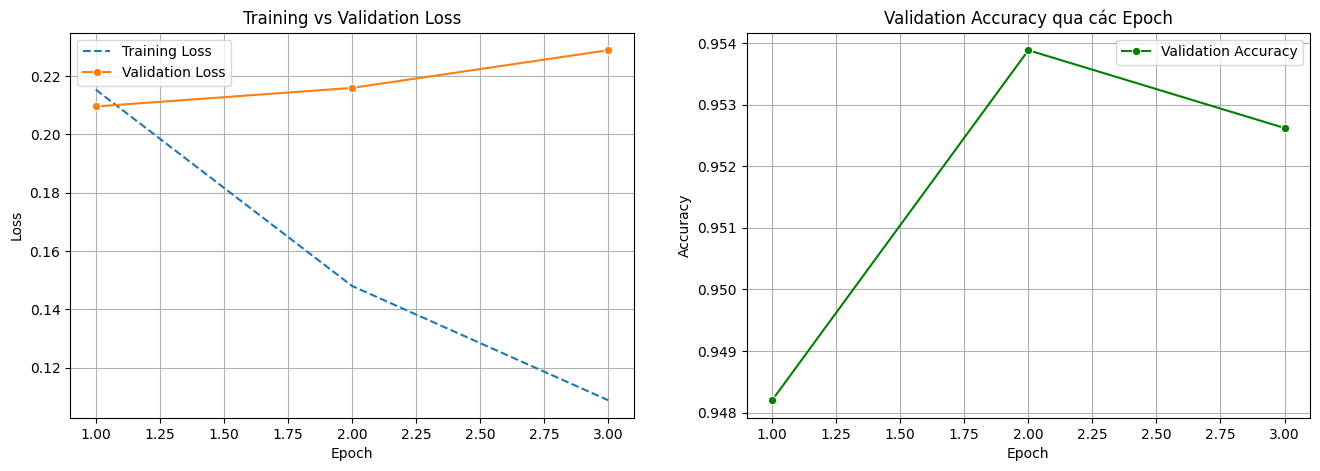

In [14]:
def plot_training_history(trainer_obj):
    # Lấy lịch sử log từ trainer
    history = trainer_obj.state.log_history

    # Tách metrics train và eval
    train_loss = []
    eval_loss = []
    eval_acc = []
    epochs = []

    for log in history:
        if "loss" in log and "epoch" in log:
            train_loss.append({'epoch': log["epoch"], 'loss': log["loss"]})
        if "eval_loss" in log and "epoch" in log:
            eval_loss.append({'epoch': log["epoch"], 'loss': log["eval_loss"]})
        if "eval_accuracy" in log and "epoch" in log:
            eval_acc.append({'epoch': log["epoch"], 'accuracy': log["eval_accuracy"]})

    df_train_loss = pd.DataFrame(train_loss)
    df_eval_loss = pd.DataFrame(eval_loss)
    df_eval_acc = pd.DataFrame(eval_acc)

    # Vẽ biểu đồ
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # 1. Loss Curve
    if not df_train_loss.empty:
        sns.lineplot(data=df_train_loss, x="epoch", y="loss", label="Training Loss", ax=axes[0], linestyle="--")
    if not df_eval_loss.empty:
        sns.lineplot(data=df_eval_loss, x="epoch", y="loss", label="Validation Loss", ax=axes[0], marker="o")
    axes[0].set_title("Training vs Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True)

    # 2. Accuracy Curve
    if not df_eval_acc.empty:
        sns.lineplot(data=df_eval_acc, x="epoch", y="accuracy", label="Validation Accuracy", ax=axes[1], color="green", marker="o")
        axes[1].set_title("Validation Accuracy qua các Epoch")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].grid(True)

    plt.show()

# Gọi hàm vẽ (Chạy sau khi trainer.train() xong)
print("--- BIỂU ĐỒ HUẤN LUYỆN (BASELINE) ---")
plot_training_history(trainer)

In [15]:
print("\n--- BẮT ĐẦU ĐÁNH GIÁ TRÊN TẬP TEST ---")

# Chạy đánh giá trên tập "test"
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])

print("\nKết quả đánh giá trên tập Test:")
print(test_results)


--- BẮT ĐẦU ĐÁNH GIÁ TRÊN TẬP TEST ---



Kết quả đánh giá trên tập Test:
{'eval_loss': 0.2719263434410095, 'eval_accuracy': 0.9355653821857233, 'eval_f1_weighted': 0.9317563814767591, 'eval_precision_weighted': 0.9312522624862586, 'eval_recall_weighted': 0.9355653821857233, 'eval_runtime': 6.5398, 'eval_samples_per_second': 484.112, 'eval_steps_per_second': 30.276, 'epoch': 3.0}


In [16]:
# 'test_results' là biến từ cell 'trainer.evaluate()' trước đó của bạn
baseline_results = test_results

print("--- Kết quả Baseline (Trước Augmentation) ---")
print(baseline_results)

--- Kết quả Baseline (Trước Augmentation) ---
{'eval_loss': 0.2719263434410095, 'eval_accuracy': 0.9355653821857233, 'eval_f1_weighted': 0.9317563814767591, 'eval_precision_weighted': 0.9312522624862586, 'eval_recall_weighted': 0.9355653821857233, 'eval_runtime': 6.5398, 'eval_samples_per_second': 484.112, 'eval_steps_per_second': 30.276, 'epoch': 3.0}


--- ĐANG DỰ ĐOÁN TRÊN TẬP TEST (BASELINE) ---


✅ Đã lưu kết quả dự đoán vào: phobert_baseline_predictions.csv

--- BIỂU ĐỒ: MA TRẬN NHẦM LẪN (BASELINE) ---


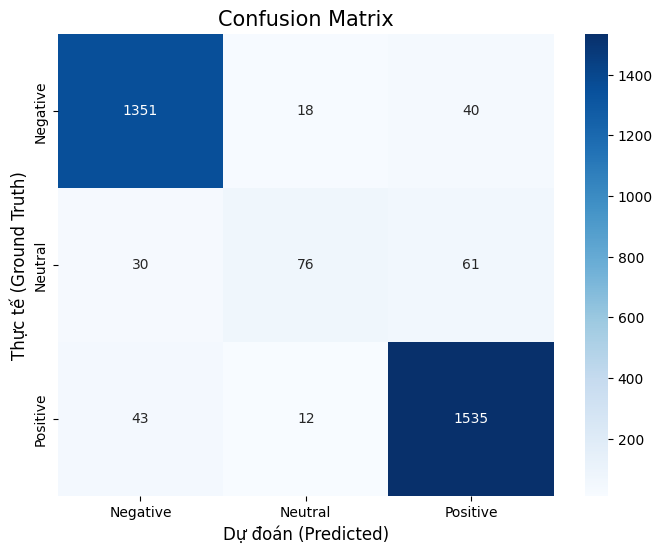

In [17]:
# --- DỰ ĐOÁN VÀ VẼ MA TRẬN NHẦM LẪN CHO BASELINE ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("--- ĐANG DỰ ĐOÁN TRÊN TẬP TEST (BASELINE) ---")

# 1. Lấy dự đoán (Logits)
predictions_output = trainer.predict(tokenized_datasets["test"])

# 2. Chuyển Logits thành nhãn ID (0, 1, 2)
predicted_label_ids = np.argmax(predictions_output.predictions, axis=-1)

# 3. Chuyển ID thành Text (negative, neutral, positive)
predicted_texts = [id2label[label_id] for label_id in predicted_label_ids]

# 4. Lấy nhãn thực tế (Ground Truth)
# Lưu ý: Lấy từ raw_datasets để đảm bảo đúng thứ tự
original_sentences = raw_datasets["test"]["sentence"]
ground_truth_labels = [id2label[label_id] for label_id in raw_datasets["test"]["sentiment"]]

# 5. Tạo DataFrame kết quả
df_results = pd.DataFrame({
    'sentence': original_sentences,
    'ground_truth': ground_truth_labels,
    'prediction': predicted_texts
})
df_results['is_correct'] = (df_results['ground_truth'] == df_results['prediction'])

# 6. Lưu file CSV
df_results.to_csv("phobert_baseline_predictions.csv", index=False, encoding='utf-8-sig')
print("✅ Đã lưu kết quả dự đoán vào: phobert_baseline_predictions.csv")

# 7. Vẽ Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=["negative", "neutral", "positive"])
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Neutral", "Positive"],
                yticklabels=["Negative", "Neutral", "Positive"], ax=ax)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Dự đoán (Predicted)', fontsize=12)
    ax.set_ylabel('Thực tế (Ground Truth)', fontsize=12)
    plt.show()

print("\n--- BIỂU ĐỒ: MA TRẬN NHẦM LẪN (BASELINE) ---")
plot_confusion_matrix(df_results['ground_truth'], df_results['prediction'])

In [19]:
# --- BLOCK 2: DATA AUGMENTATION & TOKENIZE ---
import json
import pandas as pd
from datasets import Dataset, concatenate_datasets, DatasetDict

print("\n" + "="*40)
print("  BƯỚC 3: DATA AUGMENTATION (Dùng file JSON)")
print("="*40)

synthetic_file = "final_synthetic_data_cleaned.json"

try:
    with open(synthetic_file, 'r', encoding='utf-8') as f:
        synthetic_data_list = json.load(f)
    synthetic_df = pd.DataFrame(synthetic_data_list)
except FileNotFoundError:
    print(f"❌ Lỗi: Không tìm thấy file {synthetic_file}. Vui lòng upload lại file này.")
    synthetic_df = pd.DataFrame()
except Exception as e:
    print(f"❌ Lỗi khi đọc file JSON: {e}")
    synthetic_df = pd.DataFrame()

if not synthetic_df.empty:
    synthetic_dataset = Dataset.from_pandas(synthetic_df)
    original_train_dataset = raw_datasets["train"]
    original_features = original_train_dataset.features
    synthetic_dataset = synthetic_dataset.cast(original_features)
    augmented_train_dataset = concatenate_datasets([original_train_dataset, synthetic_dataset])

    print("Tạo DatasetDict đã tăng cường...")
    augmented_datasets = DatasetDict({
        "train": augmented_train_dataset,
        "validation": raw_datasets["validation"],
        "test": raw_datasets["test"]
    })

    print(f"Đã tải {len(synthetic_df)} mẫu dữ liệu synthetic.")
    print(f"Số lượng tập train MỚI (gốc + tăng cường): {len(augmented_train_dataset)}")
else:
    print("Sử dụng dataset gốc cho các bước sau.")
    augmented_datasets = raw_datasets.copy() # Phải là .copy() của DatasetDict

print("\n--- Tokenize bộ dữ liệu đã tăng cường ---")
tokenized_augmented_datasets = augmented_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=["sentence", "topic", "sentiment"]
)
print(tokenized_augmented_datasets)


  BƯỚC 3: DATA AUGMENTATION (Dùng file JSON)


Casting the dataset:   0%|          | 0/5292 [00:00<?, ? examples/s]

Tạo DatasetDict đã tăng cường...
Đã tải 5292 mẫu dữ liệu synthetic.
Số lượng tập train MỚI (gốc + tăng cường): 16718

--- Tokenize bộ dữ liệu đã tăng cường ---


Map:   0%|          | 0/16718 [00:00<?, ? examples/s]

Map:   0%|          | 0/1583 [00:00<?, ? examples/s]

Map:   0%|          | 0/3166 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 16718
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3166
    })
})


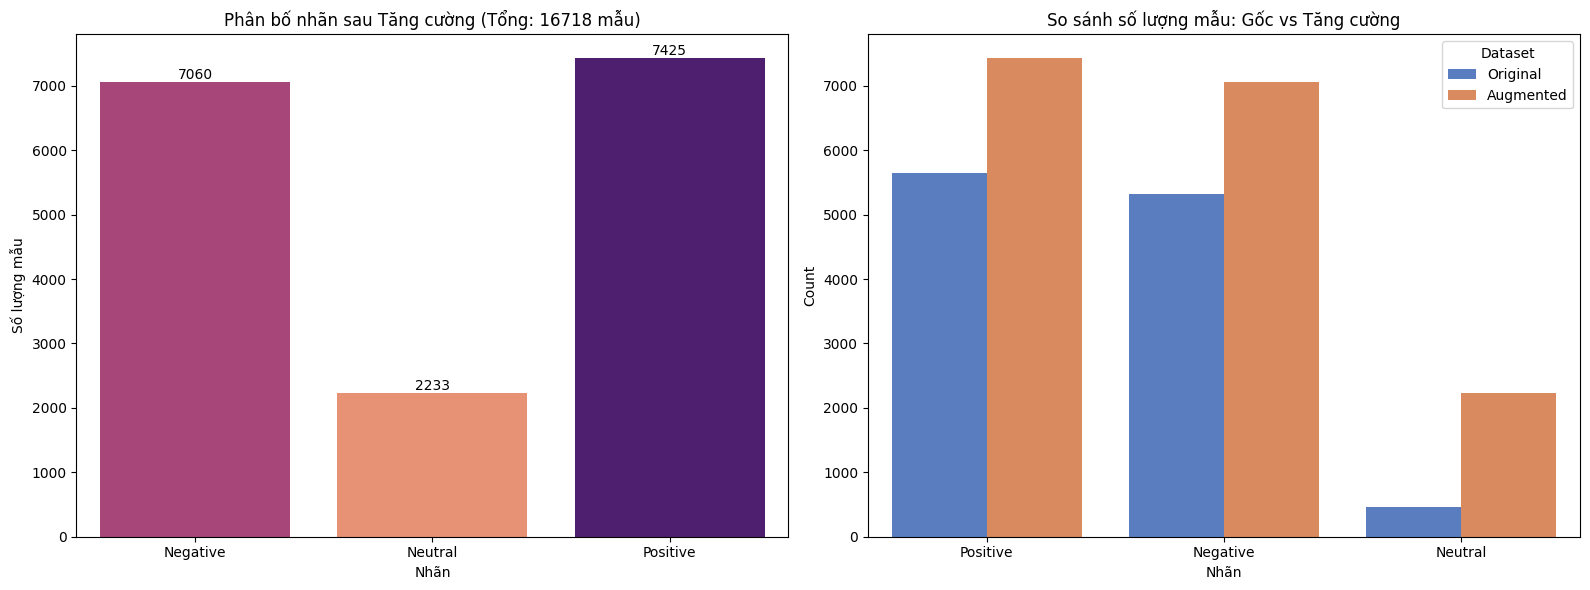

In [21]:
# --- TRỰC QUAN HÓA DỮ LIỆU SAU KHI TĂNG CƯỜNG ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Chuẩn bị dữ liệu Augmented
df_aug_train = pd.DataFrame(augmented_datasets["train"])
# Đảm bảo label_map đã được định nghĩa. Nếu chưa, định nghĩa lại:
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df_aug_train["label_text"] = df_aug_train["sentiment"].map(label_map)

# 2. Chuẩn bị dữ liệu Gốc (Kiểm tra xem df_train đã có chưa)
if 'df_train' not in locals():
    # Tạo lại nếu biến bị thiếu do chưa chạy cell trên
    if 'raw_datasets' in locals():
        df_train = pd.DataFrame(raw_datasets["train"])
        df_train["label_text"] = df_train["sentiment"].map(label_map)
    else:
        print("⚠️ Cảnh báo: Không tìm thấy dữ liệu gốc (df_train hoặc raw_datasets). Biểu đồ so sánh có thể bị lỗi.")
        df_train = df_aug_train # Fallback tạm để không crash

# --- VẼ BIỂU ĐỒ ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ 1: Phân bố nhãn sau Tăng cường
# Fix lỗi Warning: Thêm hue="label_text" và legend=False
sns.countplot(data=df_aug_train, x="label_text", hue="label_text", ax=axes[0], palette="magma", order=["Negative", "Neutral", "Positive"], legend=False)
axes[0].set_title(f"Phân bố nhãn sau Tăng cường (Tổng: {len(df_aug_train)} mẫu)")
axes[0].set_xlabel("Nhãn")
axes[0].set_ylabel("Số lượng mẫu")
for p in axes[0].patches:
    if p.get_height() > 0:
        axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Biểu đồ 2: So sánh tỷ lệ với tập gốc
# Tạo DataFrame so sánh
df_compare = pd.DataFrame({
    "Original": df_train["label_text"].value_counts(),
    "Augmented": df_aug_train["label_text"].value_counts()
})

# Đặt tên rõ ràng cho index là "index" để reset_index tạo ra cột tên đúng ý muốn
df_compare.index.name = "index"

# Reset index và melt
df_compare_melted = df_compare.reset_index().melt(id_vars="index", var_name="Dataset", value_name="Count")

sns.barplot(data=df_compare_melted, x="index", y="Count", hue="Dataset", ax=axes[1], palette="muted")
axes[1].set_title("So sánh số lượng mẫu: Gốc vs Tăng cường")
axes[1].set_xlabel("Nhãn")

plt.tight_layout()
plt.show()

In [22]:
# --- BLOCK 3: HUẤN LUYỆN LẠI MÔ HÌNH ---

# 1. TẢI LẠI MODEL GỐC
print("\n--- Tải lại model gốc vinai/phobert-base ---")
model_augmented = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# 2. TẠO TRAINER MỚI
trainer_augmented = Trainer(
    model=model_augmented,
    args=training_args,
    train_dataset=tokenized_augmented_datasets["train"],
    eval_dataset=tokenized_augmented_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 3. HUẤN LUYỆN LẠI
print(f"\n--- Bắt đầu huấn luyện mô hình MỚI trên dữ liệu tăng cường (Train size: {len(tokenized_augmented_datasets['train'])}) ---")
trainer_augmented.train()
print("--- Huấn luyện mô hình MỚI hoàn tất ---")


--- Tải lại model gốc vinai/phobert-base ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1629894019.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_augmented = Trainer(



--- Bắt đầu huấn luyện mô hình MỚI trên dữ liệu tăng cường (Train size: 16718) ---


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted
1,0.230200,0.198376,0.951990,0.949072,0.949511,0.951990
2,0.126800,0.226151,0.950095,0.947116,0.948381,0.950095
3,0.086500,0.234993,0.951990,0.948850,0.949223,0.951990


--- Huấn luyện mô hình MỚI hoàn tất ---


--- BIỂU ĐỒ HUẤN LUYỆN (AUGMENTED MODEL) ---


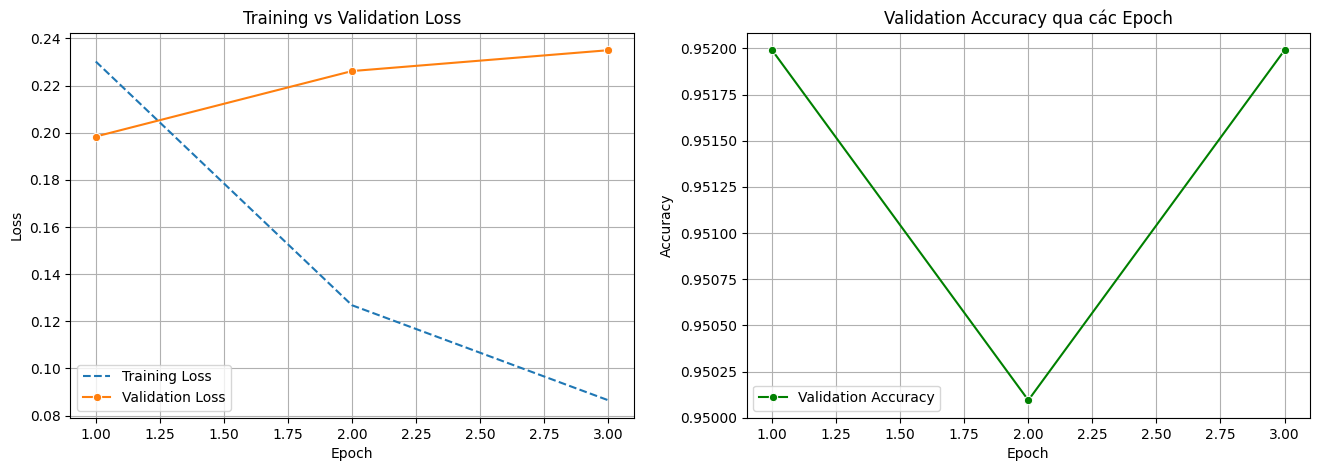

In [23]:
# Gọi hàm vẽ biểu đồ cho trainer_augmented
# Hàm plot_training_history đã được định nghĩa ở phần trước
print("--- BIỂU ĐỒ HUẤN LUYỆN (AUGMENTED MODEL) ---")
plot_training_history(trainer_augmented)


--- Đánh giá mô hình MỚI (Augmented) trên tập Test GỐC ---



--- Kết quả MỚI (Sau Augmentation) ---
{'eval_loss': 0.2547464668750763, 'eval_accuracy': 0.936197094125079, 'eval_f1_weighted': 0.9319762727029, 'eval_precision_weighted': 0.9321429843167667, 'eval_recall_weighted': 0.936197094125079, 'eval_runtime': 6.5555, 'eval_samples_per_second': 482.954, 'eval_steps_per_second': 30.204, 'epoch': 3.0}

✅ Đã lưu biểu đồ so sánh Loss: loss_comparison.png
✅ Đã lưu biểu đồ so sánh Hiệu suất: performance_comparison.png


  BẢNG SO SÁNH KẾT QUẢ TRƯỚC VÀ SAU KHI TĂNG CƯỜNG
| metric                  |   Baseline (Original) |   Augmented (Synthetic) |
|:------------------------|----------------------:|------------------------:|
| eval_loss               |                0.2719 |                  0.2547 |
| eval_accuracy           |                0.9356 |                  0.9362 |
| eval_f1_weighted        |                0.9318 |                  0.9320 |
| eval_precision_weighted |                0.9313 |                  0.9321 |
| eval_recall_weight

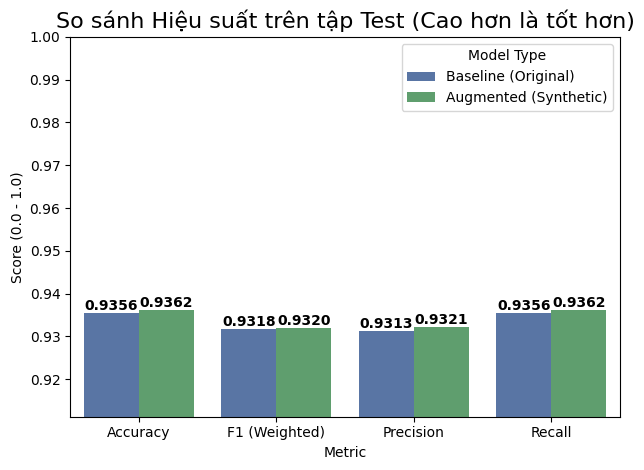

In [24]:
# --- BLOCK 4: ĐÁNH GIÁ, TRỰC QUAN HÓA VÀ SO SÁNH ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n--- Đánh giá mô hình MỚI (Augmented) trên tập Test GỐC ---")

# 1. Đánh giá trên tập test GỐC (tokenized_datasets) để so sánh công bằng
augmented_results = trainer_augmented.evaluate(eval_dataset=tokenized_datasets["test"])

print("\n--- Kết quả MỚI (Sau Augmentation) ---")
print(augmented_results)

# 2. Chuẩn bị dữ liệu cho việc vẽ đồ thị
metrics_to_plot = {
    'Loss': 'eval_loss',
    'Accuracy': 'eval_accuracy',
    'F1 (Weighted)': 'eval_f1_weighted',
    'Precision': 'eval_precision_weighted',
    'Recall': 'eval_recall_weighted'
}

plot_data = []
for friendly_name, metric_key in metrics_to_plot.items():
    # Thêm dữ liệu Baseline (từ Block 1)
    plot_data.append({
        'Metric': friendly_name,
        'Model Type': 'Baseline (Original)',
        'Score': baseline_results.get(metric_key)
    })
    # Thêm dữ liệu Augmented (vừa tính)
    plot_data.append({
        'Metric': friendly_name,
        'Model Type': 'Augmented (Synthetic)',
        'Score': augmented_results.get(metric_key)
    })

df_plot = pd.DataFrame(plot_data)

# --- 3. Vẽ Biểu đồ 1: So sánh Loss (Thấp hơn là tốt hơn) ---
df_loss = df_plot[df_plot['Metric'] == 'Loss']

plt.clf() # Xóa bất kỳ biểu đồ cũ nào
plt.rcParams['figure.figsize'] = (8, 6) # Đặt kích thước
ax_loss = sns.barplot(
    data=df_loss,
    x='Model Type',
    y='Score',
    hue='Model Type',
    palette=['#4c72b0', '#55a868'] # Xanh cho Baseline, Xanh lá cho Augmented
)
ax_loss.set_title('So sánh Mất mát trên tập Test (Loss - Thấp hơn là tốt hơn)', fontsize=14)
ax_loss.set_ylabel('Score (Loss)')
ax_loss.set_xlabel('Model Type')

# Thêm nhãn số liệu
for p in ax_loss.patches:
    ax_loss.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontweight='bold')

plt.savefig('loss_comparison.png')
print(f"\n✅ Đã lưu biểu đồ so sánh Loss: loss_comparison.png")

# --- 4. Vẽ Biểu đồ 2: So sánh Các chỉ số (Cao hơn là tốt hơn) ---
df_performance = df_plot[df_plot['Metric'] != 'Loss']

plt.clf() # Xóa biểu đồ loss
plt.rcParams['figure.figsize'] = (14, 8) # Đặt kích thước rộng hơn
ax_perf = sns.barplot(
    data=df_performance,
    x='Metric',
    y='Score',
    hue='Model Type',
    palette=['#4c72b0', '#55a868']
)
ax_perf.set_title('So sánh Hiệu suất trên tập Test (Cao hơn là tốt hơn)', fontsize=16)
ax_perf.set_ylabel('Score (0.0 - 1.0)')
ax_perf.set_xlabel('Metric')

# Điều chỉnh trục Y để thấy rõ sự khác biệt (ví dụ: từ 0.9 đến 1.0)
min_score = df_performance['Score'].min()
ax_perf.set_ylim(bottom=max(0, min_score - 0.02), top=1.0)

# Thêm nhãn số liệu
for p in ax_perf.patches:
    ax_perf.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontweight='bold')

plt.legend(title='Model Type', loc='upper right')
plt.tight_layout() # Tự động điều chỉnh cho vừa vặn
plt.savefig('performance_comparison.png')
print(f"✅ Đã lưu biểu đồ so sánh Hiệu suất: performance_comparison.png")

# --- 5. In Bảng so sánh (Như cũ) ---
metrics_to_compare = ['eval_loss', 'eval_accuracy', 'eval_f1_weighted', 'eval_precision_weighted', 'eval_recall_weighted']
comparison_dict = {
    "metric": metrics_to_compare,
    "Baseline (Original)": [baseline_results.get(m) for m in metrics_to_compare],
    "Augmented (Synthetic)": [augmented_results.get(m) for m in metrics_to_compare],
}
df_comparison = pd.DataFrame(comparison_dict).set_index("metric")

print("\n\n" + "="*40)
print("  BẢNG SO SÁNH KẾT QUẢ TRƯỚC VÀ SAU KHI TĂNG CƯỜNG")
print("="*40)
print(df_comparison.to_markdown(floatfmt=".4f"))

# --- Mức độ cải thiện (hoặc suy giảm) ---
df_comparison['Improvement (Aug. - Base)'] = (
    df_comparison['Augmented (Synthetic)'] - df_comparison['Baseline (Original)']
)
print("\n--- BẢNG MỨC ĐỘ CẢI THIỆN (HOẶC SUY GIẢM) ---")
print(df_comparison.to_markdown(floatfmt=".4f"))

--- MA TRẬN NHẦM LẪN (AUGMENTED MODEL) ---


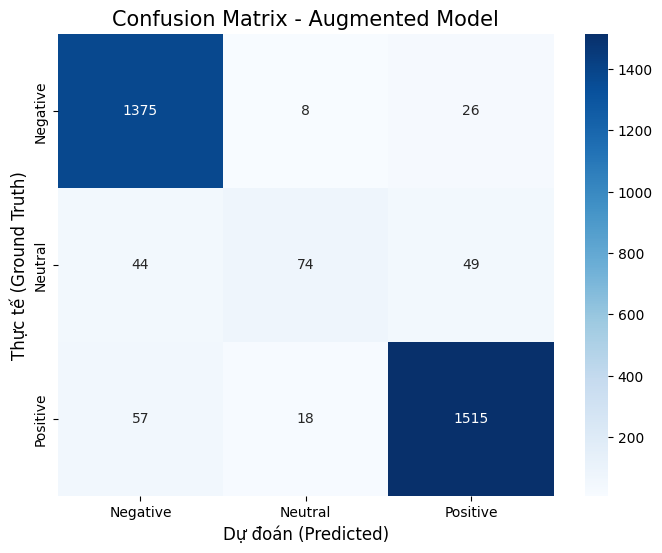

In [26]:
print("--- MA TRẬN NHẦM LẪN (AUGMENTED MODEL) ---")

# 1. Lấy dự đoán từ mô hình Augmented trên tập Test gốc
aug_pred_output = trainer_augmented.predict(tokenized_datasets["test"])

# 2. Xử lý kết quả dự đoán (Dạng số: 0, 1, 2)
aug_predictions_ids = np.argmax(aug_pred_output.predictions, axis=-1)
aug_labels_ids = aug_pred_output.label_ids

# 3. CHUYỂN ĐỔI SANG DẠNG CHỮ (String) để khớp với hàm plot_confusion_matrix
# id2label = {0: "negative", 1: "neutral", 2: "positive"} (đã định nghĩa ở đầu notebook)
aug_predictions_text = [id2label[i] for i in aug_predictions_ids]
aug_labels_text = [id2label[i] for i in aug_labels_ids]

# 4. Vẽ Confusion Matrix
# Bây giờ đầu vào đã là ["positive", "negative"...] đúng như hàm yêu cầu
plot_confusion_matrix(aug_labels_text, aug_predictions_text, title="Confusion Matrix - Augmented Model")

In [27]:
import torch
from pyvi import ViTokenizer
import warnings

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings("ignore", category=UserWarning)

print("\n" + "="*40)
print("  BƯỚC 5: KIỂM TRA (INFERENCE) 2 MÔ HÌNH")
print("="*40)

# 1. Xác định thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# 2. Lấy mô hình từ Trainer
try:
    # Lấy mô hình Baseline từ biến 'trainer' (Cell 9)
    baseline_model = trainer.model
    # Lấy mô hình Augmented từ biến 'trainer_augmented' (Cell 15)
    augmented_model = trainer_augmented.model

    # Chuyển cả 2 mô hình sang chế độ .eval() và đưa lên device
    baseline_model.to(device).eval()
    augmented_model.to(device).eval()
    print("✅ Đã tải thành công 2 mô hình (Baseline và Augmented).")

except NameError:
    print("❌ Lỗi: Không tìm thấy biến 'trainer' hoặc 'trainer_augmented'.")
    print("Vui lòng đảm bảo bạn đã chạy Cell 9 và Cell 15.")
    raise

# 3. Hàm dự đoán (Giữ nguyên)
def predict_sentiment(text, model, tokenizer, vi_tokenizer, id2label_map, device):
    segmented_text = vi_tokenizer.tokenize(text)
    inputs = tokenizer(segmented_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)

    prediction_id = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][prediction_id].item()
    predicted_label = id2label_map[prediction_id]

    return predicted_label, confidence

# 4. Danh sách câu để test tự động
test_sentences = [
    "Giáo viên giảng bài rất hay, dễ hiểu.", # Rất tích cực
    "Trường nên cải thiện cơ sở vật chất.",  # Trung lập (góp ý)
    "Học phí quá cao!",                     # Tiêu cực
    "Thư viện ồn ào, không học được.",      # Rất tiêu cực
    "Bài giảng bình thường, không có gì đặc sắc.", # Trung lập
    "Em rất hài lòng với môn học này.",     # Tích cực
    "Thầy dạy chán quá."                    # Tiêu cực
]

print("\n--- PHẦN 1: TEST TỰ ĐỘNG CÁC CÂU VÍ DỤ ---")

for sentence in test_sentences:
    print(f"\nCâu đầu vào: \"{sentence}\"")

    # Dự đoán Baseline
    label_base, conf_base = predict_sentiment(
        sentence, baseline_model, tokenizer, ViTokenizer, id2label, device
    )
    print(f"  Baseline (10 Epochs): {label_base.upper()} (Độ tự tin: {conf_base:.2%})")

    # Dự đoán Augmented
    label_aug, conf_aug = predict_sentiment(
        sentence, augmented_model, tokenizer, ViTokenizer, id2label, device
    )
    print(f"  Augmented (10 Epochs): {label_aug.upper()} (Độ tự tin: {conf_aug:.2%})")
    print("-" * 30)

# 5. Vòng lặp cho phép người dùng tự nhập câu
print("\n--- PHẦN 2: TEST TỰ NHẬP (Nhập 'quit' để thoát) ---")

while True:
    # Yêu cầu người dùng nhập câu
    sentence = input("\nNhập câu bạn muốn test: ")

    # Điều kiện thoát
    if sentence.lower() == 'quit':
        print("Đã thoát chương trình test.")
        break

    if not sentence.strip():
        print("Vui lòng nhập một câu.")
        continue

    # --- Dự đoán bằng mô hình Baseline (10 epochs) ---
    label_base, conf_base = predict_sentiment(
        sentence, baseline_model, tokenizer, ViTokenizer, id2label, device
    )
    print(f"  Baseline (10 Epochs): {label_base.upper()} (Độ tự tin: {conf_base:.2%})")

    # --- Dự đoán bằng mô hình Augmented (10 epochs) ---
    label_aug, conf_aug = predict_sentiment(
        sentence, augmented_model, tokenizer, ViTokenizer, id2label, device
    )
    print(f"  Augmented (10 Epochs): {label_aug.upper()} (Độ tự tin: {conf_aug:.2%})")
    print("-" * 30)


  BƯỚC 5: KIỂM TRA (INFERENCE) 2 MÔ HÌNH
Sử dụng thiết bị: cuda
✅ Đã tải thành công 2 mô hình (Baseline và Augmented).

--- PHẦN 1: TEST TỰ ĐỘNG CÁC CÂU VÍ DỤ ---

Câu đầu vào: "Giáo viên giảng bài rất hay, dễ hiểu."
  Baseline (10 Epochs): POSITIVE (Độ tự tin: 99.72%)
  Augmented (10 Epochs): POSITIVE (Độ tự tin: 99.62%)
------------------------------

Câu đầu vào: "Trường nên cải thiện cơ sở vật chất."
  Baseline (10 Epochs): NEGATIVE (Độ tự tin: 99.17%)
  Augmented (10 Epochs): NEGATIVE (Độ tự tin: 99.30%)
------------------------------

Câu đầu vào: "Học phí quá cao!"
  Baseline (10 Epochs): NEGATIVE (Độ tự tin: 98.83%)
  Augmented (10 Epochs): NEGATIVE (Độ tự tin: 99.26%)
------------------------------

Câu đầu vào: "Thư viện ồn ào, không học được."
  Baseline (10 Epochs): NEGATIVE (Độ tự tin: 99.04%)
  Augmented (10 Epochs): NEGATIVE (Độ tự tin: 99.45%)
------------------------------

Câu đầu vào: "Bài giảng bình thường, không có gì đặc sắc."
  Baseline (10 Epochs): NEUTRAL (Độ 

In [28]:
# --- BLOCK 6 (MỚI): LƯU CÁC MÔ HÌNH VÀ TOKENIZER ---

print("Đang lưu mô hình Baseline (từ 'trainer')...")
# 'trainer' là biến từ Cell 8, đã huấn luyện ở Cell 9
trainer.save_model("phobert-baseline-final")
print("✅ Đã lưu mô hình Baseline vào thư mục 'phobert-baseline-final'")

print("\nĐang lưu mô hình Augmented (từ 'trainer_augmented')...")
# 'trainer_augmented' là biến từ Cell 15
trainer_augmented.save_model("phobert-augmented-final")
print("✅ Đã lưu mô hình Augmented vào thư mục 'phobert-augmented-final'")

# Lưu cả tokenizer để đảm bảo lần sau load lên chính xác
tokenizer.save_pretrained("phobert-tokenizer-final")
print("✅ Đã lưu tokenizer vào thư mục 'phobert-tokenizer-final'")

Đang lưu mô hình Baseline (từ 'trainer')...
✅ Đã lưu mô hình Baseline vào thư mục 'phobert-baseline-final'

Đang lưu mô hình Augmented (từ 'trainer_augmented')...
✅ Đã lưu mô hình Augmented vào thư mục 'phobert-augmented-final'
✅ Đã lưu tokenizer vào thư mục 'phobert-tokenizer-final'


In [29]:
import os
import shutil

# --- NÉN THƯ MỤC THÀNH FILE .ZIP ---

print("Đang nén các thư mục mô hình...")

# 1. Nén mô hình Baseline
shutil.make_archive(
    base_name="phobert-baseline-final-model",  # Tên file zip (không có .zip)
    format="zip",                             # Định dạng nén
    root_dir=".",                             # Nén từ thư mục hiện tại
    base_dir="phobert-baseline-final"         # Tên thư mục cần nén
)
print("✅ Đã nén 'phobert-baseline-final-model.zip'")

# 2. Nén mô hình Augmented
shutil.make_archive(
    base_name="phobert-augmented-final-model",
    format="zip",
    root_dir=".",
    base_dir="phobert-augmented-final"
)
print("✅ Đã nén 'phobert-augmented-final-model.zip'")

# 3. Nén Tokenizer
shutil.make_archive(
    base_name="phobert-tokenizer-final",
    format="zip",
    root_dir=".",
    base_dir="phobert-tokenizer-final"
)
print("✅ Đã nén 'phobert-tokenizer-final.zip'")

print("\n--- HOÀN TẤT NÉN FILE ---")

Đang nén các thư mục mô hình...
✅ Đã nén 'phobert-baseline-final-model.zip'
✅ Đã nén 'phobert-augmented-final-model.zip'
✅ Đã nén 'phobert-tokenizer-final.zip'

--- HOÀN TẤT NÉN FILE ---


In [45]:
# Xóa các thư mục đã giải nén để test lại
!rm -rf phobert-baseline-final
!rm -rf phobert-augmented-final
!rm -rf phobert-tokenizer-final

# print("Đã xóa các thư mục đã giải nén (nếu có).")

In [46]:
from google.colab import drive
import os
import zipfile
import shutil

# 1. Kết nối Google Drive
print("🔗 Đang kết nối với Google Drive...")
drive.mount('/content/drive')

# 2. CẤU HÌNH ĐƯỜNG DẪN
# 👉 Đảm bảo đường dẫn này đúng với nơi bạn đã lưu file trên Drive
drive_source_folder = "/content/drive/MyDrive/NLP_Project_Final"

# Danh sách: "Tên file zip trên Drive" : "Tên thư mục muốn giải nén ra ở Colab"
targets = {
    "phobert-baseline-final-model.zip": "phobert-baseline-final",
    "phobert-augmented-final-model.zip": "phobert-augmented-final",
    "phobert-tokenizer-final.zip": "phobert-tokenizer-final"
}

print(f"\n--- BẮT ĐẦU LẤY DỮ LIỆU TỪ: {drive_source_folder} ---")

for zip_filename, extract_to_folder in targets.items():
    # Đường dẫn đầy đủ tới file zip trên Drive
    zip_path_on_drive = os.path.join(drive_source_folder, zip_filename)

    # 3. Kiểm tra file có tồn tại trên Drive không
    if not os.path.exists(zip_path_on_drive):
        print(f"❌ LỖI: Không tìm thấy file '{zip_filename}' trên Drive.")
        continue

    # 4. Xóa thư mục đích cũ (nếu có) để tránh file rác
    if os.path.exists(extract_to_folder):
        shutil.rmtree(extract_to_folder)

    # 5. Giải nén
    print(f"📦 Đang giải nén '{zip_filename}'...")
    try:
        with zipfile.ZipFile(zip_path_on_drive, 'r') as zip_ref:
            zip_ref.extractall(extract_to_folder)

        # === 6. XỬ LÝ LỖI LỒNG THƯ MỤC (Nested Folder Fix) ===
        # Lấy danh sách file/folder vừa giải nén ra
        files_inside = os.listdir(extract_to_folder)

        # Nếu chỉ có DUY NHẤT 1 thư mục con bên trong (ví dụ: folder/folder/...)
        if len(files_inside) == 1:
            nested_folder_path = os.path.join(extract_to_folder, files_inside[0])

            if os.path.isdir(nested_folder_path):
                print(f"   ⚠️ Phát hiện lồng thư mục: '{files_inside[0]}'. Đang sửa...")

                # Di chuyển tất cả nội dung từ thư mục con ra ngoài
                for filename in os.listdir(nested_folder_path):
                    src_file = os.path.join(nested_folder_path, filename)
                    dst_file = os.path.join(extract_to_folder, filename)
                    shutil.move(src_file, dst_file)

                # Xóa thư mục rỗng thừa
                os.rmdir(nested_folder_path)
                print("      -> Đã đưa file ra ngoài thành công.")

        print(f"   ✅ Hoàn tất: '{extract_to_folder}'")

    except zipfile.BadZipFile:
        print(f"❌ LỖI: File zip '{zip_filename}' bị hỏng.")
    except Exception as e:
        print(f"❌ LỖI KHÁC: {e}")

print("\n--- SẴN SÀNG! BẠN CÓ THỂ CHẠY TEST NGAY ---")

🔗 Đang kết nối với Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- BẮT ĐẦU LẤY DỮ LIỆU TỪ: /content/drive/MyDrive/NLP_Project_Final ---
📦 Đang giải nén 'phobert-baseline-final-model.zip'...
   ⚠️ Phát hiện lồng thư mục: 'phobert-baseline-final'. Đang sửa...
      -> Đã đưa file ra ngoài thành công.
   ✅ Hoàn tất: 'phobert-baseline-final'
📦 Đang giải nén 'phobert-augmented-final-model.zip'...
   ⚠️ Phát hiện lồng thư mục: 'phobert-augmented-final'. Đang sửa...
      -> Đã đưa file ra ngoài thành công.
   ✅ Hoàn tất: 'phobert-augmented-final'
📦 Đang giải nén 'phobert-tokenizer-final.zip'...
   ⚠️ Phát hiện lồng thư mục: 'phobert-tokenizer-final'. Đang sửa...
      -> Đã đưa file ra ngoài thành công.
   ✅ Hoàn tất: 'phobert-tokenizer-final'

--- SẴN SÀNG! BẠN CÓ THỂ CHẠY TEST NGAY ---


In [47]:
# --- BLOCK 7 (ĐỘC LẬP): CELL TEST CHO CÁC LẦN CHẠY SAU ---

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pyvi import ViTokenizer
import warnings
import os # Thêm thư viện os để kiểm tra file

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings("ignore", category=UserWarning)

print("Đang tải thư viện và các mô hình đã lưu...")

# 1. Định nghĩa các đường dẫn
MODEL_BASELINE_PATH = "phobert-baseline-final"
MODEL_AUGMENTED_PATH = "phobert-augmented-final"
TOKENIZER_PATH = "phobert-tokenizer-final"

# 2. Định nghĩa hằng số (phải khớp lúc train)
id2label = {0: "negative", 1: "neutral", 2: "positive"}

# 3. Tải Tokenizer và Models từ file đã lưu
try:
    if not os.path.exists(TOKENIZER_PATH):
        raise EnvironmentError(f"Không tìm thấy thư mục tokenizer: {TOKENIZER_PATH}")
    if not os.path.exists(MODEL_BASELINE_PATH):
        raise EnvironmentError(f"Không tìm thấy thư mục mô hình: {MODEL_BASELINE_PATH}")
    if not os.path.exists(MODEL_AUGMENTED_PATH):
        raise EnvironmentError(f"Không tìm thấy thư mục mô hình: {MODEL_AUGMENTED_PATH}")

    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
    baseline_model = AutoModelForSequenceClassification.from_pretrained(MODEL_BASELINE_PATH)
    augmented_model = AutoModelForSequenceClassification.from_pretrained(MODEL_AUGMENTED_PATH)

except EnvironmentError as e:
    print(f"❌ Lỗi: {e}")
    print("Vui lòng đảm bảo bạn đã UPLOAD và GIẢI NÉN (UNZIP) 3 thư mục đã lưu:")
    print(f"- {MODEL_BASELINE_PATH}")
    print(f"- {MODEL_AUGMENTED_PATH}")
    print(f"- {TOKENIZER_PATH}")
    # Dừng nếu không tìm thấy file
    raise

# 4. Xác định thiết bị và chuyển mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model.to(device).eval()
augmented_model.to(device).eval()
print(f"✅ Đã tải thành công 2 mô hình và tokenizer lên {device}.")

# 5. Hàm dự đoán (Giữ nguyên)
def predict_sentiment(text, model, tokenizer, vi_tokenizer, id2label_map, device):
    segmented_text = vi_tokenizer.tokenize(text)
    inputs = tokenizer(segmented_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)

    prediction_id = torch.argmax(probs, dim=-1).item()
    confidence = probs[0][prediction_id].item()
    predicted_label = id2label_map[prediction_id]

    return predicted_label, confidence

# 6. Vòng lặp cho phép người dùng tự nhập câu
print("\n--- BẮT ĐẦU TEST THỬ (Nhập 'quit' để thoát) ---")

while True:
    sentence = input("\nNhập câu bạn muốn test: ")

    if sentence.lower() == 'quit':
        print("Đã thoát chương trình test.")
        break

    if not sentence.strip():
        print("Vui lòng nhập một câu.")
        continue

    # Dự đoán Baseline
    label_base, conf_base = predict_sentiment(
        sentence, baseline_model, tokenizer, ViTokenizer, id2label, device
    )
    print(f"  Baseline Model: {label_base.upper()} (Độ tự tin: {conf_base:.2%})")

    # Dự đoán Augmented
    label_aug, conf_aug = predict_sentiment(
        sentence, augmented_model, tokenizer, ViTokenizer, id2label, device
    )
    print(f"  Augmented Model: {label_aug.upper()} (Độ tự tin: {conf_aug:.2%})")
    print("-" * 30)

Đang tải thư viện và các mô hình đã lưu...
✅ Đã tải thành công 2 mô hình và tokenizer lên cuda.

--- BẮT ĐẦU TEST THỬ (Nhập 'quit' để thoát) ---

Nhập câu bạn muốn test: quit
Đã thoát chương trình test.


In [33]:
!pip install sambanova

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.1 MB/s eta 0:00:00


✅ Đã kết nối SambaNova với model Meta-Llama-3.3-70B-Instruct

🔄 Đang chuẩn bị dữ liệu và mô hình...
✅ Đã có dữ liệu Test (3166 dòng).
   Thiết bị sử dụng: cuda
✅ Đã nạp thành công 2 Mô hình PhoBERT!

🚀 Bắt đầu chấm điểm 50 mẫu bằng SambaNova Llama-3.3...
⏳ [1/50] ✅ Tie
⏳ [2/50] ✅ Tie
⏳ [3/50] ✅ Tie
⏳ [4/50] ✅ Tie
⏳ [5/50] ✅ Tie
⏳ [6/50] ✅ Tie
⏳ [7/50] ✅ Tie
⏳ [8/50] ✅ Tie
⏳ [9/50] ✅ Tie
⏳ [10/50] ✅ Tie
⏳ [11/50] ✅ Tie
⏳ [12/50] ✅ Tie
⏳ [13/50] ✅ Tie
⏳ [14/50] ✅ Tie
⏳ [15/50] ✅ Tie
⏳ [16/50] ✅ Tie
⏳ [17/50] ✅ Tie
⏳ [18/50] ✅ Tie
⏳ [19/50] ✅ Tie
⏳ [20/50] ✅ Tie
⏳ [21/50] ✅ Tie
⏳ [22/50] ✅ Tie
⏳ [23/50] ✅ Tie
⏳ [24/50] ✅ Tie
⏳ [25/50] ✅ Tie
⏳ [26/50] ✅ Tie
⏳ [27/50] ✅ Tie
⏳ [28/50] ✅ Tie
⏳ [29/50] ✅ Tie
⏳ [30/50] ✅ Tie
⏳ [31/50] ✅ Tie
⏳ [32/50] ✅ Tie
⏳ [33/50] ✅ Tie
⏳ [34/50] ✅ Tie
⏳ [35/50] ✅ Augmented
⏳ [36/50] ✅ Tie
⏳ [37/50] ✅ Tie
⏳ [38/50] ✅ Tie
⏳ [39/50] ✅ Tie
⏳ [40/50] ✅ Tie
⏳ [41/50] ✅ Tie
⏳ [42/50] ✅ Tie
⏳ [43/50] ✅ Tie
⏳ [44/50] ✅ Tie
⏳ [45/50] ✅ Tie
⏳ [46/50] ✅ Tie
⏳ [47/50] ✅ 

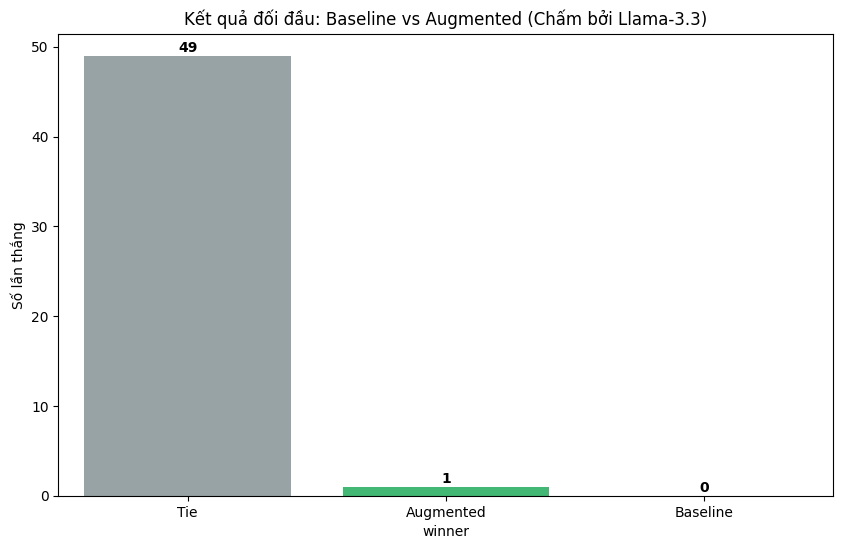


--- LÝ DO CHIẾN THẮNG CỦA AUGMENTED ---
|    | reasoning                                                                                                                                                                                |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 34 | Model A dự đoán chính xác với Nhãn Gốc là 'negative' vì câu phản hồi có chứa từ 'khó tính' mang tính tiêu cực, trong khi Model B dự đoán 'positive' không phù hợp với ngữ nghĩa của câu. |


In [38]:
import torch
import pandas as pd
import random
import time
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from openai import OpenAI # Sử dụng thư viện chuẩn OpenAI để gọi SambaNova
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pyvi import ViTokenizer
from datasets import load_dataset

# Tắt cảnh báo
warnings.filterwarnings("ignore")

# ==========================================
# 1. CẤU HÌNH SAMBANOVA CLIENT
# ==========================================
# 👇 Dán API Key SambaNova của bạn vào đây 👇
SAMBANOVA_API_KEY = "0ca5084d-75b1-4e41-bb89-f2c29ed1a412"

# Khởi tạo Client (SambaNova tương thích chuẩn OpenAI)
client = OpenAI(
    api_key=SAMBANOVA_API_KEY,
    base_url="https://api.sambanova.ai/v1",
)

print(f"✅ Đã kết nối SambaNova với model Meta-Llama-3.3-70B-Instruct")

# ==========================================
# 2. CHUẨN BỊ DỮ LIỆU & MÔ HÌNH (GIỮ NGUYÊN)
# ==========================================
print("\n🔄 Đang chuẩn bị dữ liệu và mô hình...")

# --- Bước A: Tải dữ liệu Test ---
try:
    if 'test_df' not in globals(): # Kiểm tra nếu chưa có thì mới tải
        print("⏳ Đang tải file test từ HuggingFace...")
        base_url = "https://huggingface.co/datasets/uitnlp/vietnamese_students_feedback/resolve/refs/convert/parquet/default/"
        raw_test = load_dataset("parquet", data_files={"test": base_url + "test/0000.parquet"})
        test_df = pd.DataFrame(raw_test["test"])
    print(f"✅ Đã có dữ liệu Test ({len(test_df)} dòng).")
except Exception as e:
    print(f"❌ Lỗi tải data: {e}")
    # Data giả lập phòng hờ
    test_df = pd.DataFrame([{"sentence": "Thầy dạy hay", "sentiment": 2}, {"sentence": "Chán quá", "sentiment": 0}])

# --- Bước B: Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Thiết bị sử dụng: {device}")

try:
    # 1. Tokenizer
    if os.path.exists("phobert-tokenizer-final"):
        tokenizer = AutoTokenizer.from_pretrained("phobert-tokenizer-final")
    else:
        tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

    # 2. Model Baseline
    if 'trainer' in globals() and hasattr(trainer, 'model'):
        model_baseline = trainer.model
    else:
        model_baseline = AutoModelForSequenceClassification.from_pretrained("phobert-baseline-final")
    model_baseline.to(device).eval()

    # 3. Model Augmented
    if 'trainer_augmented' in globals() and hasattr(trainer_augmented, 'model'):
        model_augmented = trainer_augmented.model
    else:
        model_augmented = AutoModelForSequenceClassification.from_pretrained("phobert-augmented-final")
    model_augmented.to(device).eval()

    print("✅ Đã nạp thành công 2 Mô hình PhoBERT!")

except Exception as e:
    print(f"❌ Lỗi nạp mô hình: {e}")

# Map nhãn
id2label = {0: "negative", 1: "neutral", 2: "positive"}

# ==========================================
# 3. HÀM DỰ ĐOÁN & CHẤM ĐIỂM (DÙNG SAMBANOVA)
# ==========================================
def get_prediction(text, model):
    segmented_text = ViTokenizer.tokenize(text)
    inputs = tokenizer(segmented_text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_id = torch.argmax(probs, dim=-1).item()
    return id2label[pred_id]

def run_judge_with_sambanova(sentence, ground_truth, ans_a, ans_b, max_retries=3):
    # Prompt System: Định nghĩa vai trò
    system_prompt = """
    Bạn là một chuyên gia ngôn ngữ học tiếng Việt. Nhiệm vụ của bạn là so sánh kết quả phân loại cảm xúc của 2 mô hình AI.
    Trả về kết quả CHỈ DƯỚI DẠNG JSON với các trường: "reasoning" (giải thích ngắn gọn) và "winner" ("A", "B", hoặc "Tie").
    Không thêm bất kỳ markdown hay text thừa nào.
    """

    # Prompt User: Cung cấp dữ liệu cụ thể
    user_prompt = f"""
    Câu phản hồi: "{sentence}"
    Nhãn Gốc (Ground Truth): "{ground_truth}"

    Model A dự đoán: "{ans_a}"
    Model B dự đoán: "{ans_b}"

    Hãy đánh giá:
    1. Độ chính xác so với Nhãn Gốc.
    2. Nếu Nhãn Gốc có vẻ sai (nhiễu), hãy chọn Model có dự đoán hợp lý hơn về ngữ nghĩa.

    Ai thắng? (A / B / Tie)
    JSON Output:
    """

    for attempt in range(max_retries):
        try:
            # Gọi API SambaNova (Llama 3.3)
            response = client.chat.completions.create(
                model="Meta-Llama-3.3-70B-Instruct",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.1, # Giữ thấp để kết quả nhất quán
                top_p=0.1
            )

            # Xử lý kết quả trả về
            content = response.choices[0].message.content
            # Lọc bỏ markdown json nếu có
            content = content.replace('```json', '').replace('```', '').strip()
            return json.loads(content)

        except Exception as e:
            if attempt == max_retries - 1:
                return {"winner": "Tie", "reasoning": f"Error: {str(e)}"}
            time.sleep(1) # Đợi xíu rồi thử lại

    return {"winner": "Tie", "reasoning": "Timeout"}

# ==========================================
# 4. CHẠY ĐÁNH GIÁ
# ==========================================
SAMPLE_SIZE = 50 # Số lượng mẫu để test

if 'test_df' in locals() and not test_df.empty:
    sample_test = test_df.sample(n=min(SAMPLE_SIZE, len(test_df)), random_state=42).reset_index(drop=True)
    results = []

    print(f"\n🚀 Bắt đầu chấm điểm {len(sample_test)} mẫu bằng SambaNova Llama-3.3...", flush=True)

    for i, row in sample_test.iterrows():
        s = row['sentence']
        gt = id2label[row['sentiment']] if isinstance(row['sentiment'], int) else row['sentiment']

        print(f"⏳ [{i+1}/{len(sample_test)}]", end=" ", flush=True)

        try:
            # 1. Dự đoán
            pred_base = get_prediction(s, model_baseline)
            pred_aug = get_prediction(s, model_augmented)

            # 2. Chấm điểm (Ngẫu nhiên vị trí để công bằng)
            if random.choice([True, False]):
                # A=Base, B=Aug
                res = run_judge_with_sambanova(s, gt, pred_base, pred_aug)
                winner = "Baseline" if res.get('winner') == "A" else ("Augmented" if res.get('winner') == "B" else "Tie")
            else:
                # A=Aug, B=Base
                res = run_judge_with_sambanova(s, gt, pred_aug, pred_base)
                winner = "Augmented" if res.get('winner') == "A" else ("Baseline" if res.get('winner') == "B" else "Tie")

            results.append({"winner": winner, "reasoning": res.get("reasoning")})
            print(f"✅ {winner}", flush=True)

        except Exception as e:
            print(f"❌ Lỗi: {e}", flush=True)

    # ==========================================
    # 5. VẼ BIỂU ĐỒ
    # ==========================================
    if results:
        print("\n📊 Đang vẽ biểu đồ...", flush=True)
        df_res = pd.DataFrame(results)
        counts = df_res['winner'].value_counts()

        plt.figure(figsize=(10, 6))
        colors = {'Augmented': '#2ecc71', 'Baseline': '#e74c3c', 'Tie': '#95a5a6'}
        for label in colors.keys():
            if label not in counts: counts[label] = 0

        ax = sns.barplot(x=counts.index, y=counts.values, palette=colors)
        plt.title("Kết quả đối đầu: Baseline vs Augmented (Chấm bởi Llama-3.3)")
        plt.ylabel("Số lần thắng")

        for i, v in enumerate(counts.values):
            ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

        plt.savefig("ket_qua_so_sanh_sambanova.png")
        plt.show()

        print("\n--- LÝ DO CHIẾN THẮNG CỦA AUGMENTED ---")
        aug_wins = df_res[df_res['winner'] == 'Augmented']
        if not aug_wins.empty:
            print(aug_wins[['reasoning']].head(10).to_markdown())
        else:
            print("Model Augmented chưa vượt trội ở mẫu thử này.")
else:
    print("❌ Không có dữ liệu.")

🔥 BẮT ĐẦU STRESS TEST MỞ RỘNG (40 MẪU) 🔥
⏳ Đang chạy dự đoán cho 40 câu test...
📊 Đang vẽ biểu đồ so sánh...


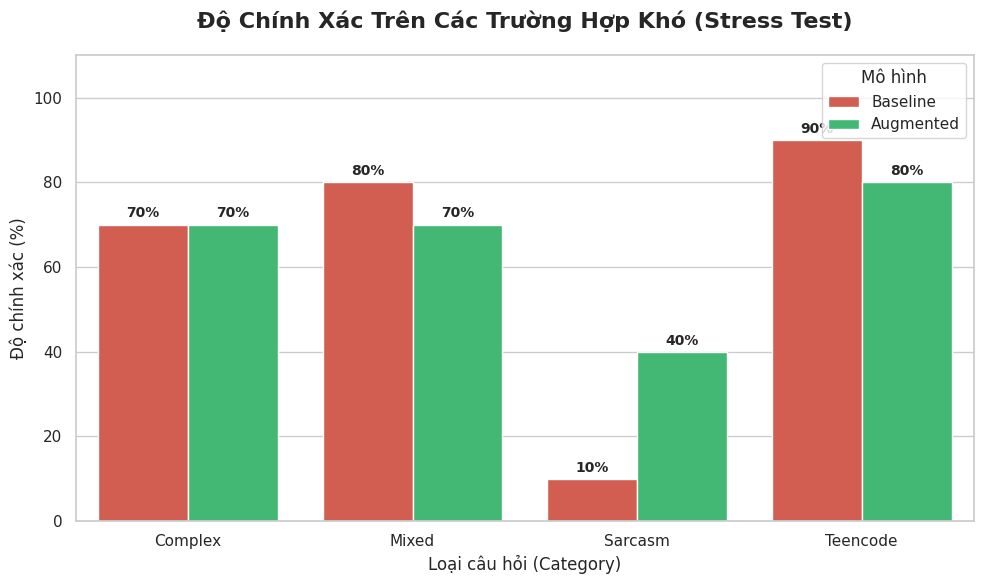


🏆 TỔNG KẾT CHUNG (OVERALL ACCURACY)
📉 Baseline Model:  62.5%
📈 Augmented Model: 65.0%
👉 Chênh lệch:      +2.5%


In [40]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyvi import ViTokenizer

print("🔥 BẮT ĐẦU STRESS TEST MỞ RỘNG (40 MẪU) 🔥")

# ==========================================
# 1. BỘ DỮ LIỆU STRESS TEST MỞ RỘNG (10 câu/loại)
# ==========================================
stress_cases = [
    # --- LOẠI 1: TEENCODE & VIẾT TẮT (10 câu) ---
    {"text": "thầy dạy j mà chán òm, hơm hỉu j hết trơn á", "type": "Teencode", "expected": "negative"},
    {"text": "môn này bao hay, học là ghiền nha quý dị", "type": "Teencode", "expected": "positive"},
    {"text": "ko thik cách dạy của cô chút nào, bùn ngủ mún xỉu", "type": "Teencode", "expected": "negative"},
    {"text": "bài giảng hay wa trời wa đất lun á", "type": "Teencode", "expected": "positive"},
    {"text": "thầy cute xỉu, giảng bài cực cuốn lun mn ơi", "type": "Teencode", "expected": "positive"},
    {"text": "nói chung là hông có j để chê hết trơn á", "type": "Teencode", "expected": "positive"},
    {"text": "phòng học nóng mún điên, ko học dc j hít", "type": "Teencode", "expected": "negative"},
    {"text": "slide nhìn rối mắt mún chít, ko hỉu j lun", "type": "Teencode", "expected": "negative"},
    {"text": "thầy giảng hơi nhanh, nhìu lúc nghe ko kịp j hít", "type": "Teencode", "expected": "negative"},
    {"text": "đề thi j mà khó dã man con ngan, rớt chắc rùi", "type": "Teencode", "expected": "negative"},

    # --- LOẠI 2: MỈA MAI / SARCASM (10 câu) ---
    {"text": "Cảm ơn thầy đã giúp em có một giấc ngủ ngon suốt 3 tiếng.", "type": "Sarcasm", "expected": "negative"},
    {"text": "Đề thi dễ lắm, dễ rớt.", "type": "Sarcasm", "expected": "negative"},
    {"text": "Giảng viên nhiệt tình ghê, hỏi gì cũng kêu tự về đọc sách.", "type": "Sarcasm", "expected": "negative"},
    {"text": "Môn học tuyệt vời đến mức em muốn học lại lần nữa vào kỳ sau.", "type": "Sarcasm", "expected": "negative"}, # Ý là rớt môn
    {"text": "Wifi trường mạnh quá, load cái trang web mất có 10 phút thôi.", "type": "Sarcasm", "expected": "negative"},
    {"text": "Cảm ơn nhà trường đã tạo điều kiện cho em tắm hơi trong phòng học.", "type": "Sarcasm", "expected": "negative"}, # Phòng nóng
    {"text": "Thầy giảng hay đến nỗi cả lớp gục xuống bàn suy ngẫm.", "type": "Sarcasm", "expected": "negative"}, # Ngủ gục
    {"text": "Giáo trình cập nhật ghê, toàn kiến thức từ năm 1900 hồi đó.", "type": "Sarcasm", "expected": "negative"},
    {"text": "Gửi xe ở trường tiện lắm, tìm chỗ đậu xe hết cả thanh xuân.", "type": "Sarcasm", "expected": "negative"},
    {"text": "Nhà vệ sinh sạch sẽ quá, bước vào là muốn nín thở luôn.", "type": "Sarcasm", "expected": "negative"},

    # --- LOẠI 3: CÂU PHỨC / PHỦ ĐỊNH KÉP (10 câu) ---
    {"text": "Không phải là tôi không thích môn này, nhưng cách truyền đạt chưa tốt.", "type": "Complex", "expected": "negative"},
    {"text": "Chưa bao giờ thấy môn nào mà giáo viên tâm huyết như vậy, không chê vào đâu được.", "type": "Complex", "expected": "positive"},
    {"text": "Tôi không nghĩ là môn học này tệ, chỉ là nó không phù hợp với tôi.", "type": "Complex", "expected": "neutral"}, # Hoặc Negative nhẹ
    {"text": "Không thể phủ nhận là cơ sở vật chất đã tốt hơn rất nhiều.", "type": "Complex", "expected": "positive"},
    {"text": "Đừng ai nói thầy dạy dở nha, thầy dạy cực kỳ có tâm đấy.", "type": "Complex", "expected": "positive"},
    {"text": "Không có buổi học nào mà em cảm thấy lãng phí thời gian cả.", "type": "Complex", "expected": "positive"},
    {"text": "Chẳng có gì để phàn nàn về chất lượng giảng dạy.", "type": "Complex", "expected": "positive"},
    {"text": "Không phải em không muốn đi học, mà là thầy dạy chán quá.", "type": "Complex", "expected": "negative"},
    {"text": "Hiếm khi thấy giảng viên nào nhiệt tình trả lời email lúc nửa đêm như cô.", "type": "Complex", "expected": "positive"},
    {"text": "Không thể nói là hài lòng với cách chấm điểm này được.", "type": "Complex", "expected": "negative"},

    # --- LOẠI 4: CẢM XÚC TRÁI CHIỀU / MIXED (10 câu) ---
    {"text": "Thầy dạy hay nhưng phòng học nóng quá không tập trung nổi.", "type": "Mixed", "expected": "negative"}, # Ưu tiên Negative vì ảnh hưởng kết quả
    {"text": "Nội dung môn học thì khô khan nhưng thầy dạy rất cuốn hút, hài hước.", "type": "Mixed", "expected": "positive"},
    {"text": "Đề thi khó nhưng thầy chấm điểm khá thoáng.", "type": "Mixed", "expected": "positive"},
    {"text": "Thư viện đẹp, sách nhiều nhưng wifi quá yếu.", "type": "Mixed", "expected": "negative"}, # Thường feedback về wifi là chê
    {"text": "Học phí cao nhưng chất lượng giảng dạy xứng đáng.", "type": "Mixed", "expected": "positive"},
    {"text": "Giảng viên giỏi chuyên môn nhưng truyền đạt hơi khó hiểu.", "type": "Mixed", "expected": "negative"}, # Dạy khó hiểu là điểm trừ lớn
    {"text": "Trường rộng đẹp nhưng đi bộ mỏi chân muốn xỉu.", "type": "Mixed", "expected": "neutral"}, # Hoặc Negative nhẹ
    {"text": "Gửi xe rẻ nhưng bác bảo vệ hơi khó tính.", "type": "Mixed", "expected": "neutral"},
    {"text": "Môn học rất bổ ích, tuy nhiên bài tập về nhà quá nhiều.", "type": "Mixed", "expected": "negative"}, # Áp lực
    {"text": "Lớp học vui, bạn bè hòa đồng, mỗi tội thầy hay điểm danh đột xuất.", "type": "Mixed", "expected": "positive"} # Vẫn vui
]

# ==========================================
# 2. HÀM DỰ ĐOÁN (Sử dụng lại từ các cell trước)
# ==========================================
def get_prediction_label(text, model):
    segmented_text = ViTokenizer.tokenize(text)
    inputs = tokenizer(segmented_text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_id = torch.argmax(probs, dim=-1).item()
    return id2label[pred_id]

# ==========================================
# 3. CHẠY TEST & TÍNH TOÁN
# ==========================================
results_data = []

print("⏳ Đang chạy dự đoán cho 40 câu test...")
for case in stress_cases:
    s = case["text"]
    expected = case["expected"]
    cat_type = case["type"]

    # Dự đoán
    pred_base = get_prediction_label(s, model_baseline)
    pred_aug = get_prediction_label(s, model_augmented)

    # Kiểm tra đúng sai
    base_correct = 1 if pred_base == expected else 0
    aug_correct = 1 if pred_aug == expected else 0

    results_data.append({
        "Type": cat_type,
        "Baseline": base_correct,
        "Augmented": aug_correct
    })

# Tạo DataFrame
df_results = pd.DataFrame(results_data)

# Tính độ chính xác theo từng loại (Accuracy per Category)
df_summary = df_results.groupby("Type")[["Baseline", "Augmented"]].mean() * 100 # Đổi ra %

# ==========================================
# 4. VẼ BIỂU ĐỒ (GROUPED BAR CHART)
# ==========================================
print("📊 Đang vẽ biểu đồ so sánh...")

# Chuyển đổi dữ liệu để vẽ (Melt)
df_plot = df_summary.reset_index().melt(id_vars="Type", var_name="Model", value_name="Accuracy")

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Vẽ biểu đồ cột
ax = sns.barplot(
    data=df_plot,
    x="Type",
    y="Accuracy",
    hue="Model",
    palette={'Baseline': '#e74c3c', 'Augmented': '#2ecc71'} # Đỏ vs Xanh lá
)

# Trang trí biểu đồ
plt.title("Độ Chính Xác Trên Các Trường Hợp Khó (Stress Test)", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Độ chính xác (%)", fontsize=12)
plt.xlabel("Loại câu hỏi (Category)", fontsize=12)
plt.ylim(0, 110) # Để chừa chỗ cho số liệu
plt.legend(title="Mô hình", loc='upper right')

# Thêm số liệu lên đầu cột
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2., height + 1,
                f'{height:.0f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# ==========================================
# 5. IN BẢNG CHI TIẾT (TÙY CHỌN ĐỂ SOI LỖI)
# ==========================================
# Tính tổng thể
total_base = df_results["Baseline"].mean() * 100
total_aug = df_results["Augmented"].mean() * 100

print("\n" + "="*40)
print("🏆 TỔNG KẾT CHUNG (OVERALL ACCURACY)")
print("="*40)
print(f"📉 Baseline Model:  {total_base:.1f}%")
print(f"📈 Augmented Model: {total_aug:.1f}%")
print(f"👉 Chênh lệch:      {total_aug - total_base:+.1f}%")

In [42]:
from google.colab import drive
import shutil
import os

# 1. Kết nối Google Drive
print("🔗 Đang kết nối với Google Drive...")
drive.mount('/content/drive')

# 2. Danh sách 3 file cần lưu (Tên phải khớp với lúc bạn nén)
files_to_save = [
    "phobert-baseline-final-model.zip",
    "phobert-augmented-final-model.zip",
    "phobert-tokenizer-final.zip"
]

# 3. Định nghĩa thư mục đích trên Drive
# Mình đặt tên folder là NLP_Project_Final để dễ tìm, bạn có thể đổi tên khác
destination_folder = "/content/drive/MyDrive/NLP_Project_Final"

# Tạo thư mục nếu chưa có
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    print(f"📁 Đã tạo thư mục mới trên Drive: {destination_folder}")
else:
    print(f"📂 Thư mục đã tồn tại: {destination_folder}")

# 4. Vòng lặp copy từng file
print(f"\n🚀 Bắt đầu sao chép {len(files_to_save)} file sang Drive...")

for file_name in files_to_save:
    # Đường dẫn file gốc trên Colab
    source_path = os.path.join(".", file_name)
    # Đường dẫn đích trên Drive
    dest_path = os.path.join(destination_folder, file_name)

    if os.path.exists(source_path):
        try:
            print(f"   ... Đang copy: {file_name} (Vui lòng đợi)")
            shutil.copy(source_path, dest_path)
            print(f"   ✅ Đã lưu thành công: {file_name}")
        except Exception as e:
            print(f"   ❌ Lỗi khi copy {file_name}: {e}")
    else:
        print(f"   ⚠️ Lỗi: Không tìm thấy file '{file_name}' trên Colab. Bạn đã chạy lệnh nén chưa?")

print("\n🎉 HOÀN TẤT! Tất cả các file đã được backup an toàn trên Google Drive.")
print(f"👉 Link thư mục: {destination_folder}")

🔗 Đang kết nối với Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Đã tạo thư mục mới trên Drive: /content/drive/MyDrive/NLP_Project_Final

🚀 Bắt đầu sao chép 3 file sang Drive...
   ... Đang copy: phobert-baseline-final-model.zip (Vui lòng đợi)
   ✅ Đã lưu thành công: phobert-baseline-final-model.zip
   ... Đang copy: phobert-augmented-final-model.zip (Vui lòng đợi)
   ✅ Đã lưu thành công: phobert-augmented-final-model.zip
   ... Đang copy: phobert-tokenizer-final.zip (Vui lòng đợi)
   ✅ Đã lưu thành công: phobert-tokenizer-final.zip

🎉 HOÀN TẤT! Tất cả các file đã được backup an toàn trên Google Drive.
👉 Link thư mục: /content/drive/MyDrive/NLP_Project_Final
